<a href="https://colab.research.google.com/github/Alexnder77/DeepLearning--methods-and-applications/blob/main/Lab5_Laboration_on_RL_V_2_Cart_pole.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Laboration on Reinforcement Learning (RL) for Pole Cart Gym


with code from Tomas Nordström and Kalle Prorok

This uses the CartPole environment from OpenAI's gym: https://gym.openai.com/ or more specificly: https://github.com/openai/gym/blob/master/gym/envs/classic_control/cartpole.py (Note that this is a Bang-Bang controller with no neutral operation, that is, it either moves left of it moves right in each time step). The original code from a paper by Sutton can be found at http://incompleteideas.net/sutton/book/code/pole.c



##**Instruktioner**

Du ska nu experimentera med Q-learning för ett miniproblem ”Cart-pole” och försöka få den inverterade pendeln på en vagn att stå upp så länge som möjligt.

- Plotta hur mycket belöning systemet får för varje episod för att se hur systemet beter sig över tid? 
- Vilka 4 mätvärden ingår i tillståndsinformationen som är grund för om man ska putta vagnen till höger eller vänster?

Gör gärna fler experiment med samma parameteruppsättning för att också få en känsla för hur stabila resultaten är. En sammanlagd reward, dvs hur många steg som systemet lyckas få pinnen att fortsätta stå upp, på mer än 180 räknas som mycket bra.

Testa med några olika parametervärden, t ex öka antalet episoder för att få en känsla för när resultaten börjar stabilisera sig; öka/minska inlärningstakten; eller t.o.m. öka kvantifieringen av tillståndsrymden (men inte för mycket då det ju gör Q-tabellen rejält mycket större för varje steg). Även Epsilon, som styr hur girig (exploit) den ska vara att ta ett slumpmässigt beslut för sin ”action” kan vara intressant att experimentera med.

För att bättre förstå, de troligen mediokra resultaten, ska du även undersöka Q-tabellen efter träningen. Hur mycket av “världen” har systemet utforskat? Vad säger detta om Q-learning som metod och kan du komma på något som skulle förbättra systemets prestanda och stabilitet.

Med en anpassning av epsilon och inlärningshastighet över tid (börja högt för att möjliggöra mer utforskning och inlärning till en början och sedan senare minska värdet för att stabilisera) kan förbättra prestandan avsevärt. Se Geron Kapitel 18 "exploration policies". Implementera detta (är kanske 4-5 rader kod!) för att se om det hjälper, men se till att jämföra med fallet då dessa parametrar är oföränderliga.

**Historik**
* 2020-05-06 Initial version 
* 2020-05-07 Uppdaterade instruktionerna (ersatte fjolårets som glömts kvar)
* 2020-12-07 Ersatte argmax med en biblioteksfunktion


# Set up the Colab environment

In [ ]:
# Select Tensorflow 2.0
%tensorflow_version 2.x

Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.


In [ ]:
# Import needed libraries
import tensorflow as tf
print('TensorFlow version:', tf.__version__)

import tensorflow.keras
import tensorflow.keras as keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, GRU
from tensorflow.keras.layers import Conv1D
from tensorflow.keras.layers import Dropout, BatchNormalization
from tensorflow.keras.layers import Flatten
from tensorflow.keras.utils import to_categorical
print('Keras version:',tensorflow.keras.__version__)

# Helper libraries
import os
import numpy as np
import pandas as pd
import cv2
import sklearn
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.preprocessing import MinMaxScaler
from numpy import argmax

# Matlab plotting
import matplotlib
import matplotlib.pyplot as plt

# For this Lab
import random
import gym

TensorFlow version: 2.9.2
Keras version: 2.9.0


In [ ]:
# Test for GPU and determine what GPU we have
# Could also use https://github.com/anderskm/gputil
import sys
if not tf.config.list_physical_devices('GPU'):
    print("No GPU was detected. CNNs can be very slow without a GPU.")
    IN_COLAB = 'google.colab' in sys.modules
    if IN_COLAB:
        print("Go to Runtime > Change runtime and select a GPU hardware accelerator.")
else:
    !nvidia-smi -L

GPU 0: Tesla T4 (UUID: GPU-e2e8efd3-e0d3-913a-872f-dc6a38f409c0)


# Define some useful functions

In [ ]:
def running_mean(x, N=10):
    """ Return the running mean of N element in a list
    """
    cumsum = np.cumsum(np.insert(x, 0, 0)) 
    return (cumsum[N:] - cumsum[:-N]) / float(N)


In [ ]:
# function to plot the results from training with labels for the parameters
def Plot_fig():
  # Plot the results from a training run
  fig = plt.figure(figsize=(16, 4))
  plt.plot(episode_reward,"b")
  y_av = running_mean(episode_reward, N=100)
  plt.plot(y_av,"r")

  # add titel with the parameters
  titel_string = "EPISODES = " + str(EPISODES) + ", GAMMA = " + str(GAMMA) + ", DISCRETE_STEPS = " + str(DISCRETE_STEPS) + "\n LEARNING_RATE = " + str(LEARNING_RATE)  + ", EPSILON = " + str(EPSILON)
  plt.title(titel_string)

  return fig

# The Main RL Code

## Model 1 
(Discrete_steps = 20, ingen förändring av epsilon & learning rate)

In [ ]:
# Inspired by RL researchers and written by Kalle Prorok for a Deep Learning Course
# Umeå Sweden 2019

# A set of parameters that is working well
EPISODES       = 15000  # Number of eposides to run, org. val was only 1000, but that is way too little #org 15000
EPSILON        = 0.1    # Chance to explore (take a radom step instead of an "optimal" one), org val = 0.1
GAMMA          = 0.9    # How much previous steps should be rewarded now, discount rate, org val = 0.9
LEARNING_RATE  = 0.1    # Learning rate, org val = 0.1
DISCRETE_STEPS = 20     # discretization steps per state variable (aviod odd numbers), org val = 10 ## prova 12 14 <------------

# The state space is the four dimensions: x, x_dot, theta, theta_dot
def make_state(observation):
    """ Map a 4-dimensional state to a state index
    """
    low = [-4.8, -10., -0.41888, -10.] # ( changed -0.41 into more correct -0.41888 for 24 deg.)
    high = [4.8, 10., 0.41888, 10.]
    state = 0

    for i in range(4):
        # State variable, projected to the [0, 1] range
        state_variable = (observation[i] - low[i]) / (high[i] - low[i])

        # Discretize. A variable having a value of 0.53 will lead to the integer 5,
        # for instance.
        state_discrete = int(state_variable * DISCRETE_STEPS)
        state_discrete = max(0, state_discrete) # should not be needed
        state_discrete = min(DISCRETE_STEPS-1, state_discrete)

        state *= DISCRETE_STEPS
        state += state_discrete
        # Make state into a 4 "digit" number (between 0 and 9999, if 10 discrete steps)
    return state


In [ ]:
# (Compare to https://www.geeksforgeeks.org/q-learning-in-python/ )
average_cumulative_reward = 0.0

episode_reward = np.zeros(EPISODES)
# Create the Gym environment (CartPole)
env = gym.make('CartPole-v1')

print('Action space is:', env.action_space)
print('Observation space is:', env.observation_space)

# Q-table for the discretized states, and two actions
num_states = DISCRETE_STEPS ** 4
qtable = [[0., 0.] for state in range(num_states)]
print('Q-table = %.0f x %.0f' % (len(qtable),len(qtable[0])))

# Loop over episodes
# Code to make the training animated
# https://stackoverflow.com/questions/52726475/display-openai-gym-in-jupyter-notebook-only

for i in range(EPISODES):
    state4D = env.reset()
    state = make_state(state4D)

    terminate = False
    cumulative_reward = 0.0

    # Loop over time-steps
    while not terminate:
        # Compute what the greedy action for the current state is
        qvalues = qtable[state]
        greedy_action = argmax(qvalues)

        # Sometimes, the agent takes a random action, to explore the environment
        if random.random() < EPSILON:
            action = random.randrange(2)
        else:
            action = greedy_action

        # Perform the action
        next_state, reward, terminate, info = env.step(action)  # info is ignored
        next_state = make_state(next_state)
        
        # Update the Q-Table
        td_error = reward + GAMMA * max(qtable[next_state]) - qtable[state][action]
        qtable[state][action] += LEARNING_RATE * td_error
        # Update statistics
        cumulative_reward += reward
        state = next_state

    # store reward for every episode
    episode_reward[i] = cumulative_reward

    ###########################################################
    # Adapt epsilon and learning rate here
    ############################################################
    
    # Per-episode statistics
    if ((i % 500)==0):
      print(i, cumulative_reward, sep=',')

/usr/local/lib/python3.7/dist-packages/gym/core.py:318: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  "Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future."
/usr/local/lib/python3.7/dist-packages/gym/wrappers/step_api_compatibility.py:40: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  "Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future."


Action space is: Discrete(2)
Observation space is: Box([-4.8000002e+00 -3.4028235e+38 -4.1887903e-01 -3.4028235e+38], [4.8000002e+00 3.4028235e+38 4.1887903e-01 3.4028235e+38], (4,), float32)
Q-table = 160000 x 2
0,15.0
500,112.0
1000,21.0
1500,77.0
2000,84.0
2500,78.0
3000,43.0
3500,64.0
4000,131.0
4500,172.0
5000,191.0
5500,104.0
6000,111.0
6500,105.0
7000,112.0
7500,125.0
8000,117.0
8500,178.0
9000,118.0
9500,129.0
10000,101.0
10500,140.0
11000,130.0
11500,120.0
12000,126.0
12500,166.0
13000,89.0
13500,57.0
14000,133.0
14500,142.0


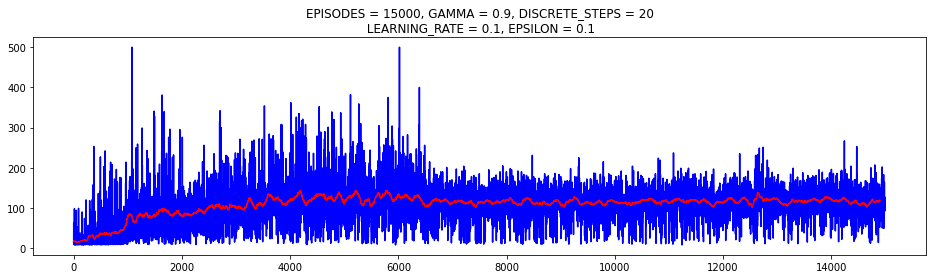

In [ ]:
Model_1 = [Plot_fig(), qtable]

## Model 2
Decayed-epsilon-greedy & learning rate decay

In [ ]:
#kod inspirerad från 
#https://stackoverflow.com/questions/53198503/epsilon-and-learning-rate-decay-in-epsilon-greedy-q-learning

# A set of parameters that is working very well
EPISODES = 15000 # Number of eposides to run, org. vat was only l000, but that is way too little
GAMMA = 0.95   #How much prew. steps should be rewarded, discount rate org value = 0.9
DISCRETE_STEPS = 20 # discretization steps per state variable (aviod odd numbers), org vat 10

EPSILON = 0 # just an initial value to avaoid errors while running the code bellow 
LEARNING_RATE = 1 #just an initial value to avaoid errors while running the code bellow

# Epsilon values will be determined by the "Decayed-epsilon-greedy" method
# source: https://stackoverflow.com/questions/53198503/epsilon-and-learning-rate-decay-in-epsilon-greedy-q-learning
p_init = 0.6 #chance to explore at the start   
p_end = 0.01 #chance to explore at the end      

# using the learning rate decay method given in the follwoing article:
#https://medium.com/analytics-vidhya/learning-rate-decay-and-methods-in-deep-learning-2cee564f910b
initial_learning_rate = 0.5 #learning rate at start
learning_decay = 0.0001 #decay per episode


In [ ]:
# (Compare to https://www.geeksforgeeks.org/q-learning-in-python/ )
average_cumulative_reward = 0.0

episode_reward = np.zeros(EPISODES)
# Create the Gym environment (CartPole)
env = gym.make('CartPole-v1')

print('Action space is:', env.action_space)
print('Observation space is:', env.observation_space)

# Q-table for the discretized states, and two actions
num_states = DISCRETE_STEPS ** 4
qtable = [[0., 0.] for state in range(num_states)]
print('Q-table = %.0f x %.0f' % (len(qtable),len(qtable[0]) ))

# Loop over episodes
# Code to make the training animated
# https://stackoverflow.com/questions/52726475/display-openai-gym-in-jupyter-notebook-only


for i in range(EPISODES):
    state4D = env.reset()
    state = make_state(state4D)

    terminate = False
    cumulative_reward = 0.0

    # Loop over time-steps
    while not terminate:
        # Compute what the greedy action for the current state is
        qvalues = qtable[state]
        greedy_action = argmax(qvalues)

        # Sometimes, the agent takes a random action, to explore the environment
        if random.random() < EPSILON:
            action = random.randrange(2)
        else:
            action = greedy_action

        # Perform the action
        next_state, reward, terminate, info = env.step(action)  # info is ignored
        next_state = make_state(next_state)

        # Update the Q-Table
        td_error = reward + GAMMA * max(qtable[next_state]) - qtable[state][action]
        qtable[state][action] += LEARNING_RATE * td_error
        # Update statistics
        cumulative_reward += reward
        state = next_state

    # store reward for every episode
    episode_reward[i] = cumulative_reward

    ###########################################################
    # Adapt epsilon and learning rate here

    # Update EPSILON according to the "Decayed-epsilon-greedy" method
    r = np.max((EPISODES-i)/EPISODES,0)
    EPSILON = (p_init - p_end)*r + p_end

    #update learning_rate
    LEARNING_RATE =  1/(1+i*learning_decay)*initial_learning_rate
    ############################################################
    
    # Per-episode statistics
    if ((i % 500)==0):
      print(i, cumulative_reward, sep=',')

/usr/local/lib/python3.7/dist-packages/gym/core.py:318: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  "Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future."
/usr/local/lib/python3.7/dist-packages/gym/wrappers/step_api_compatibility.py:40: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  "Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future."


Action space is: Discrete(2)
Observation space is: Box([-4.8000002e+00 -3.4028235e+38 -4.1887903e-01 -3.4028235e+38], [4.8000002e+00 3.4028235e+38 4.1887903e-01 3.4028235e+38], (4,), float32)
Q-table = 160000 x 2
0,10.0
500,66.0
1000,46.0
1500,39.0
2000,30.0
2500,18.0
3000,38.0
3500,24.0
4000,28.0
4500,124.0
5000,219.0
5500,69.0
6000,122.0
6500,68.0
7000,73.0
7500,12.0
8000,145.0
8500,162.0
9000,22.0
9500,460.0
10000,260.0
10500,198.0
11000,204.0
11500,500.0
12000,274.0
12500,114.0
13000,98.0
13500,158.0
14000,433.0
14500,334.0


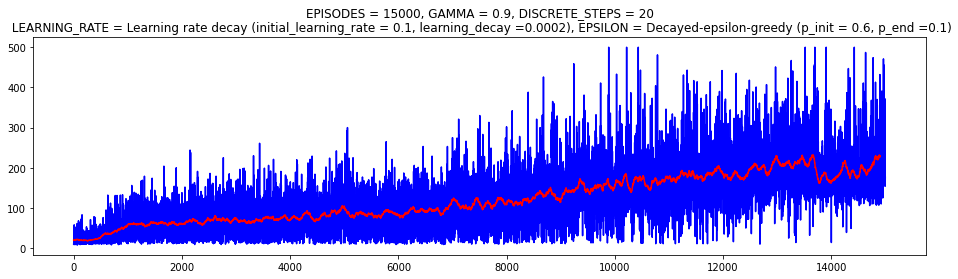

In [ ]:
EPSILON = "Decayed-epsilon-greedy (p_init = " + str(p_init) + ", p_end =" + str(p_end) + ")"
LEARNING_RATE = "Learning rate decay (initial_learning_rate = " + str(initial_learning_rate) + ", learning_decay =" + str(learning_decay) + ")"

model_2_01 = [Plot_fig(),qtable]

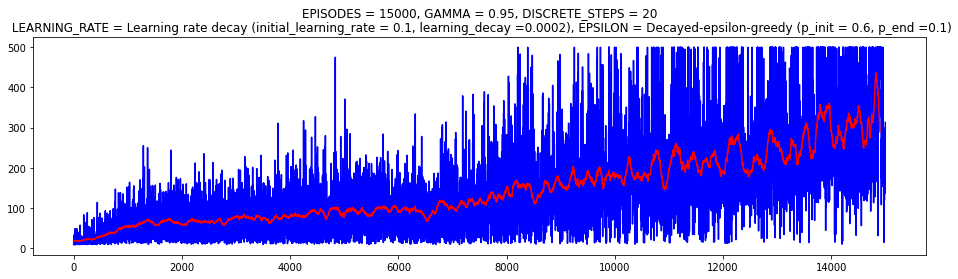

In [ ]:
EPSILON = "Decayed-epsilon-greedy (p_init = " + str(p_init) + ", p_end =" + str(p_end) + ")"
LEARNING_RATE = "Learning rate decay (initial_learning_rate = " + str(initial_learning_rate) + ", learning_decay =" + str(learning_decay) + ")"

model_2_02 = [Plot_fig(),qtable]

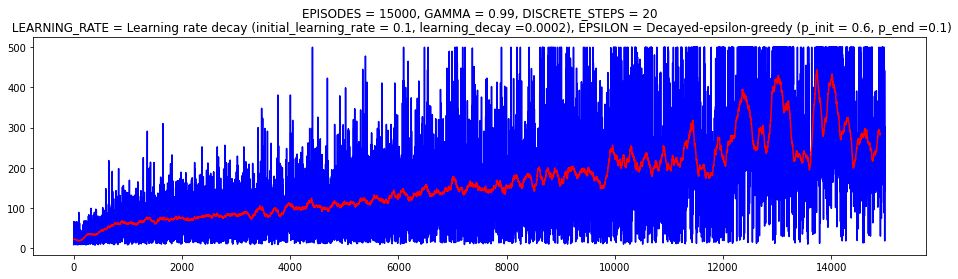

In [ ]:
EPSILON = "Decayed-epsilon-greedy (p_init = " + str(p_init) + ", p_end =" + str(p_end) + ")"
LEARNING_RATE = "Learning rate decay (initial_learning_rate = " + str(initial_learning_rate) + ", learning_decay =" + str(learning_decay) + ")"

model_2_03 = [Plot_fig(),qtable]

These last 2 graphs are very unstable in the later episodes -> which makes me feel that I should lower the p_end value, also GAMMA = 0.95 seems to do a little better than 0.99

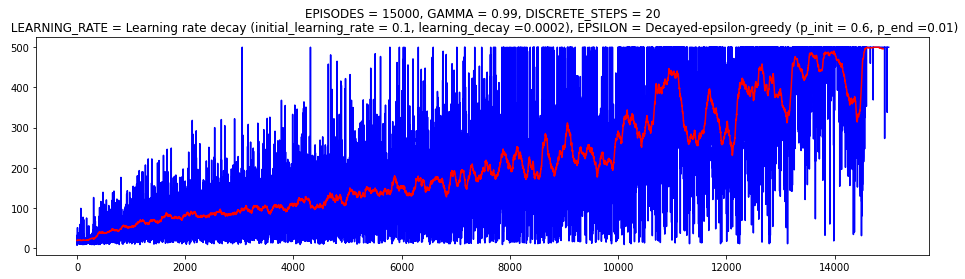

In [ ]:
EPSILON = "Decayed-epsilon-greedy (p_init = " + str(p_init) + ", p_end =" + str(p_end) + ")"
LEARNING_RATE = "Learning rate decay (initial_learning_rate = " + str(initial_learning_rate) + ", learning_decay =" + str(learning_decay) + ")"

model_2_04 = [Plot_fig(),qtable]

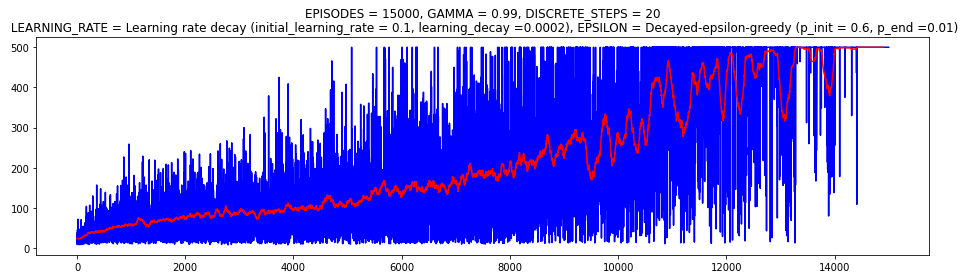

In [ ]:
EPSILON = "Decayed-epsilon-greedy (p_init = " + str(p_init) + ", p_end =" + str(p_end) + ")"
LEARNING_RATE = "Learning rate decay (initial_learning_rate = " + str(initial_learning_rate) + ", learning_decay =" + str(learning_decay) + ")"

model_2_05 = [Plot_fig(),qtable]

these last 3 are doing pretty well, but they seem to be extremely unstable, but after runing the last one twice we can see that both of them get very high values towards the end, but lowering the GAMMA value will probably make them more stable..

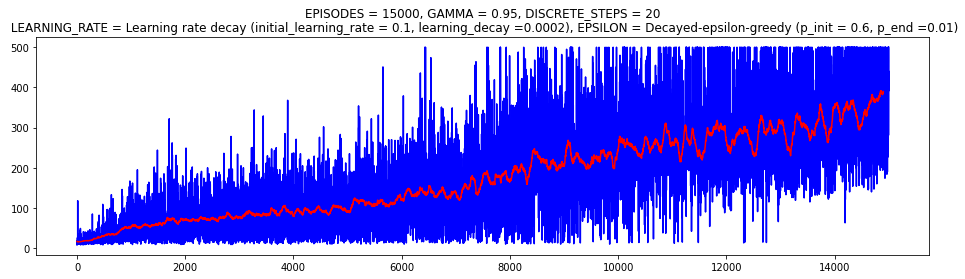

In [ ]:
EPSILON = "Decayed-epsilon-greedy (p_init = " + str(p_init) + ", p_end =" + str(p_end) + ")"
LEARNING_RATE = "Learning rate decay (initial_learning_rate = " + str(initial_learning_rate) + ", learning_decay =" + str(learning_decay) + ")"

model_2_06 = [Plot_fig(),qtable]

this one is way more stable and running it for longer would probably result in even better results, but 200 is already considered very good so to keep running this when it has already reached 400 seems unnecesary 

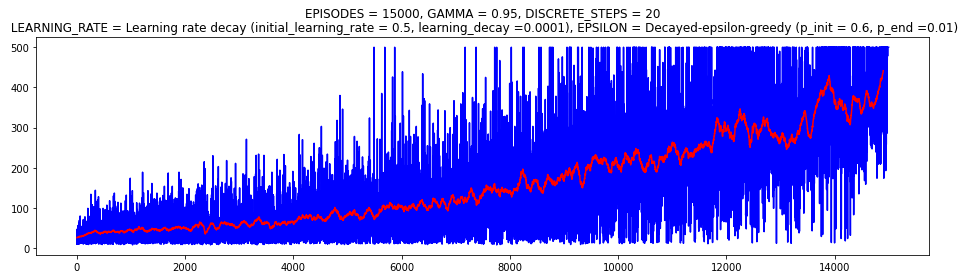

In [ ]:
EPSILON = "Decayed-epsilon-greedy (p_init = " + str(p_init) + ", p_end =" + str(p_end) + ")"
LEARNING_RATE = "Learning rate decay (initial_learning_rate = " + str(initial_learning_rate) + ", learning_decay =" + str(learning_decay) + ")"

model_2_07 = [Plot_fig(),qtable]

# Analys

De 4 värden som ingår i tillståndsinformationen:
1. Vagnens horisontella position (O = center, x)
2. Vagnens hastighet (där positiv = höger, x_dot)
3. Pinnens vinkel (theta)
4. Pinnens vinkelhastighet (där positiv = medurs, theta_dot)

Jag började med att köra koden utan någon förändring av epsilon & learning rate (båda hade konstant värdet 0,1). Jag experiemnterade där efter med de olika parametrarna, provade olika värden på antalet episoder, Epison och Learning rate, men värdena var ganska svårtolkade och det var svårt att se något mönster. 

Men något som var tydligt var att en ökad tillståndsrymd förbättrade resultatet ganska krafftigt. Discrete_steps = 20, med övriga värden som orginal värden gav ett resultat på ca 100 vilket känndes som en bra "baseline model". 

Efter att ha experiemterat lite med olika funktioner för epsilon och learning rate, där iprincip alla mina försök med "linjära"/simpla metoder drog ner resultated markant så hittade jag ett forum från https://stackoverflow.com/questions/53198503/epsilon-and-learning-rate-decay-in-epsilon-greedy-q-learning
där dem diskuterar "decayed-epsilon-greedy" och "Learning rate decay". jag provade att aplicera dessa funktioner/modeller och såg en väldigt stor förbättring. Några av de värdena jag provade att sätta in i dessa funktionerna finns plottade här ovan. 

# Q-table

## Q-table Modell 1

In [ ]:
print(Model_1[1])

[[0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.

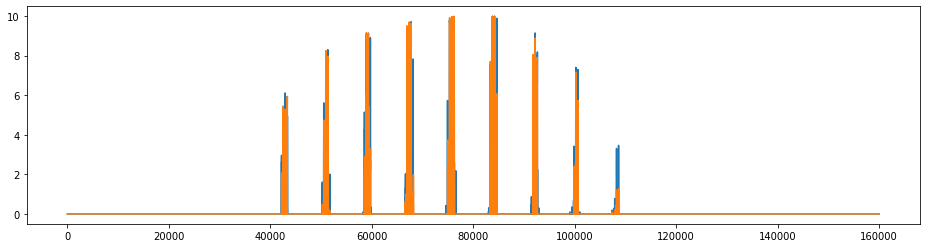

In [ ]:
plt.figure(figsize=(16, 4))
plt.plot(Model_1[1])

In [ ]:
#kod inspirerad av det som gavs i diskussions forumet 
nonzeroind = np.nonzero(Model_1[1])
nononz = len(nonzeroind[1])
print('Nummber of non-zero elements in q-table', nononz, '=', nononz/num_states*100,'% of the values')

Nummber of non-zero elements in q-table 1178 = 0.73625 % of the values


## Q-tabel Modell 2

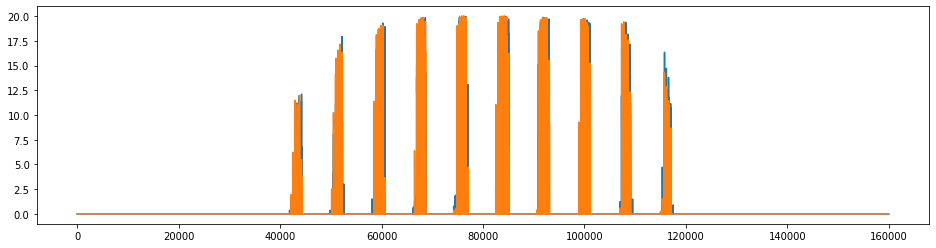

In [ ]:
plt.figure(figsize=(16, 4))
plt.plot(model_2_07[1])

In [ ]:
#kod inspirerad av det som gavs i diskussions forumet 
nonzeroind = np.nonzero(model_2_07[1])
nononz = len(nonzeroind[1])
print('Nummber of non-zero elements in q-table', nononz, '=', nononz/num_states*100,'% of the values')

Nummber of non-zero elements in q-table 3152 = 1.97 % of the values


## Q-table analys
När det kommer till hur mycket av "världen" modellerna har utforskat så ser vi ovan att modell 1 har utforskat ca 0.74% och modell 2 (2.7) ca 1.97% så runt 1% av världarna är utforskade. vilket spontant känns som väldigt lite. 

Men eftersom att vi uppdaterar q-tabelen på ett sätt som prioriterar de värdena som mäst sanolikt kommer inträffa och vi ändå lyckas få ett så pass bra resultat så känns det som att det kanske räcker ändå. 

Ett sätt att förbättra systemets prestanda är att istället för att använda en q-tabel använda så kallade "Deep Q-network", där de olika in värdena behandlas av neuronnät